# Mall Customer Segmentation Analysis

Github:

https://github.com/MatthewFisher126/unsupervised_ml_class/tree/main

This notebook will look at mall customer data which contains data such as Customer ID, age, gender, annual income and spending score. The goal of this notebook is to use multiple unsupervised machine learning models in order to assign customers to clusters. Different clusters can be used in different marketing strategies for these customers. 

Unsupervised machine learning can be used to reduce dimensions or cluster the data finding unrecognized patterns. 

I am using a Kaggle dataset and it can be found here:

https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

In [25]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, silhouette_score, make_scorer
from sklearn.preprocessing import StandardScaler
import random

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv


In [26]:
# Read in the data. 
data = pd.read_csv('/kaggle/input/customer-segmentation-tutorial-in-python/Mall_Customers.csv')

## Exploratory Data Analysis

First I will explore the data, look at the data types of the columns, see if there are any null values or duplicates to fill or remove, and look at correlation of the columns. 

In [27]:
# Look at the top few rows, get the shape, and info of the data. 
print(data.head())
print(data.shape)
print(data.info())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40
(200, 5)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None


As mentioned before, there are columns Customer ID, age, gender, annual income and spending score. There are 200 rows of data consisting of those 5 columns. As for our datatypes, they seem to fit the columns well.

In [28]:
# Check for null values.
print(data.isnull().sum())

# Test to see if there are duplicates.
print(data.nunique())

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64
CustomerID                200
Gender                      2
Age                        51
Annual Income (k$)         64
Spending Score (1-100)     84
dtype: int64


There are no null values for any of the columns and there are 200 unique CustomerIDs. There are also 51 unique values for Age, 64 unique values for Annual Income, and 84 unique values for Spending Score. 

In [29]:
# Compute the summary stats each column.
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Minimum Age is 18 which makes sense because you probably can't be a supermarket member without being 18+. The max Age is 70 which also makes sense. The other columns seem reasonable. 

   CustomerID  Gender  Age  Income  Score
0           1    Male   19      15     39
1           2    Male   21      15     81
2           3  Female   20      16      6
3           4  Female   23      16     77
4           5  Female   31      17     40


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

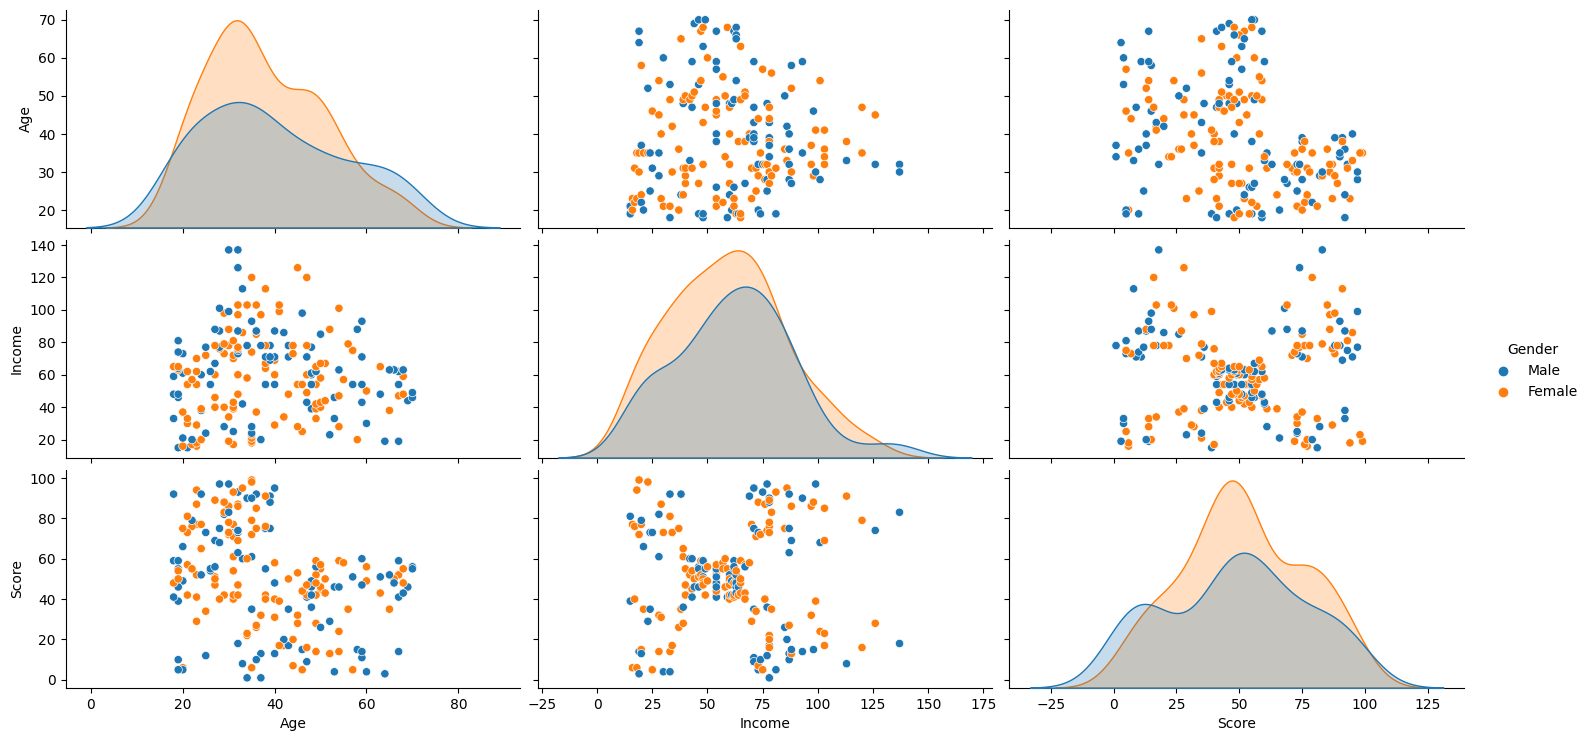

In [30]:
# Rename some columns so it is easier to work with in the future. 
data.rename(index=str, columns={'Annual Income (k$)': 'Income','Spending Score (1-100)': 'Score'}, inplace=True)
print(data.head())

# Plot a correlation plot. 
sns.pairplot(data.drop(['CustomerID'], axis=1), hue='Gender', aspect=2)
plt.show()

There appears to be no correlation between the different columns but to make sure I will make a heatmap.

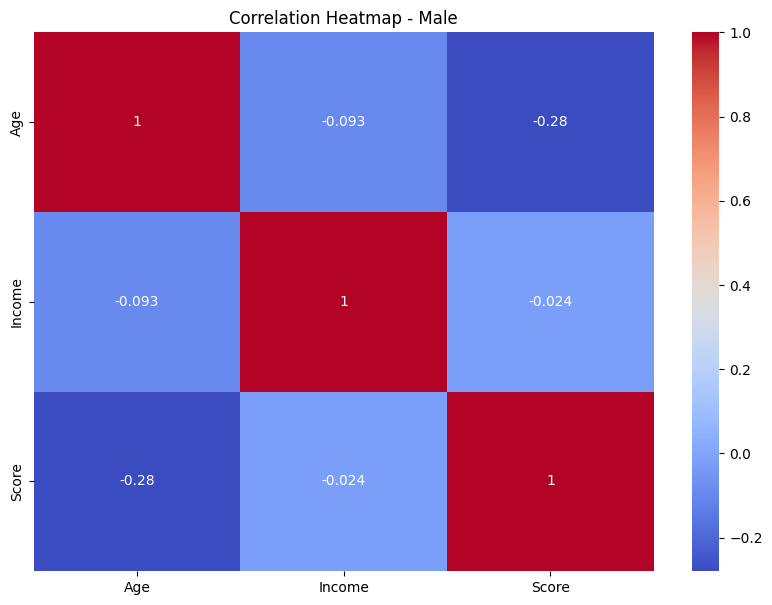

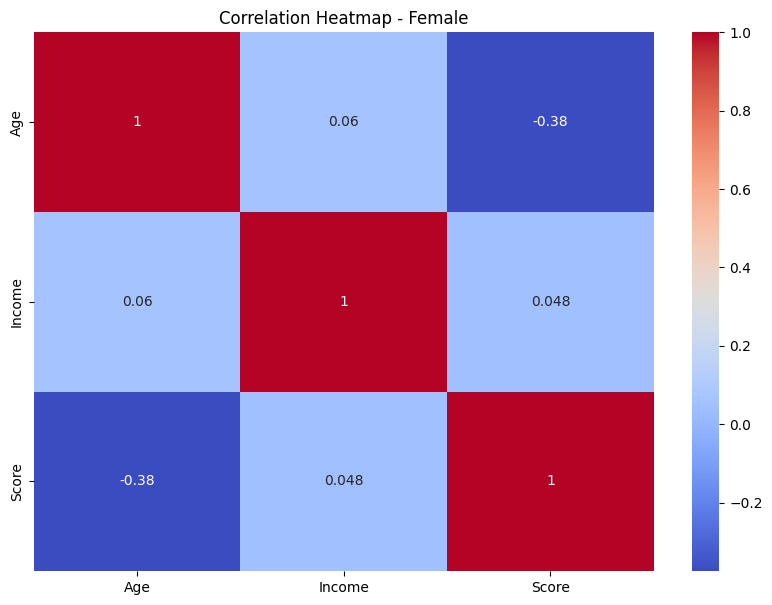

In [31]:
# Calculate correlations for male data.
corr_male = data[data['Gender'] == "Male"].drop(['CustomerID', 'Gender'], axis=1).corr()

# Create a heatmap for male data.
plt.figure(figsize=(10,7))
sns.heatmap(corr_male, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Male')
plt.show()

# Calculate correlations for female data.
corr_female = data[data['Gender'] == "Female"].drop(['CustomerID', 'Gender'], axis=1).corr()

# Create a heatmap for female data.
plt.figure(figsize=(10,7))
sns.heatmap(corr_female, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Female')
plt.show()


Once again, there doesn't seem to be much correlation between the columns.

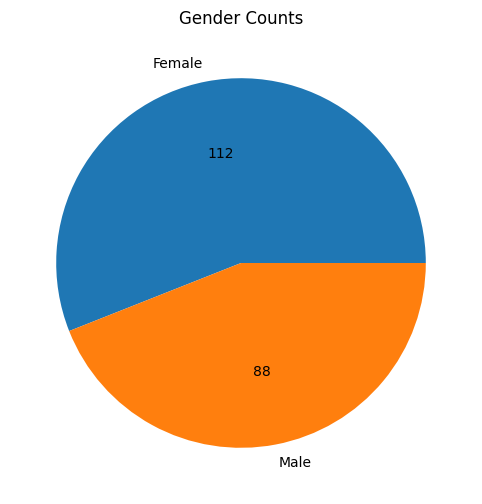

In [32]:
# Count the genders.
gender_counts = data['Gender'].value_counts()

# Create a pie chart.
plt.figure(figsize=(10,6))
plt.pie(gender_counts, labels = gender_counts.index, autopct=lambda p: '{:.0f}'.format(p * sum(gender_counts) / 100))
plt.title('Gender Counts')
plt.show()


There are 88 males and 112 females in the data.

## Unsupervised learning

### PCA

If this data was really large (which it is not), then we might want to run a PCA on it and reduce our dimensions. This would allow us to condense important data down to less dimensions which would be easier to work with (less space and more efficient).

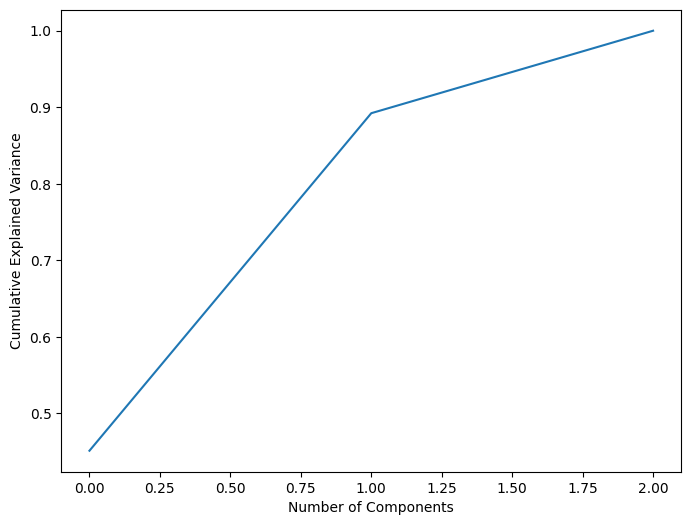

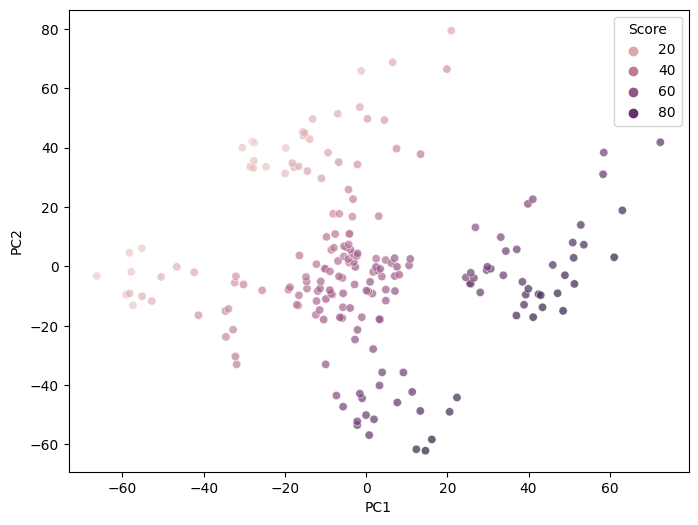

In [33]:
# Select the numerical columns.
numerical_cols = ['Age', 'Income', 'Score']
X = data[numerical_cols]

# Apply PCA.
pca = PCA()
X_pca = pca.fit_transform(X)

# Plot the explained variance.
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Plot PC1 vs PC2.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], 
            hue=data['Score'], 
            alpha=0.7
           )
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


~100% of the data can be explained in 2 PCs. This is reasonable since there is only 200 rows but if there were more data then more PCs would be needed. Since we want to cluster people, I colored the PCA plot using Score. We can already see people kind of clustering or in groups where higher scores are on the right, medium scores in the middle, and lower scores are on the left side. 

### Clustering

Next, I want to cluster the data. The first thing I want to explore before clustering is how many clusters I might want to give my algorithms (kmeans and AgglomerativeClustering). One way to explore this is to use the inertia of the algorithms. The inertia is a way to look at how well the algorithm clustered the data. When plotting the inertia, we are looking for sharper breaks or elbows when going to the next cluster. These sharp breaks might be a number of clusters we want to explore futher. 


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

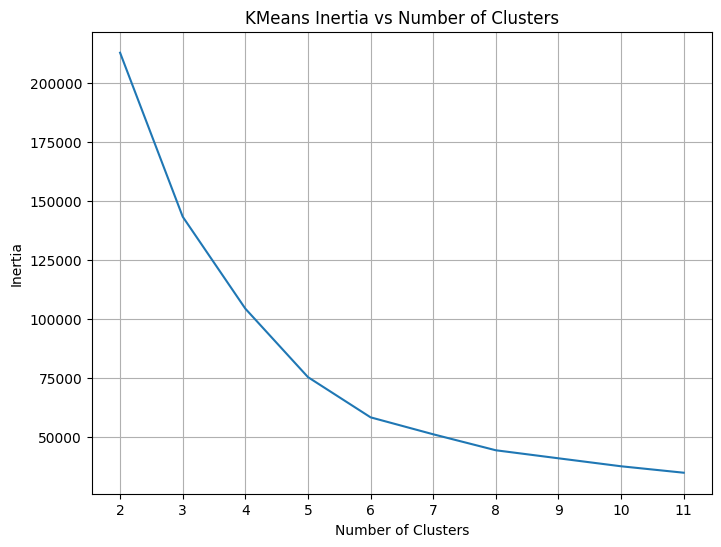

In [34]:
# List to save the inertia for each number of clusters.
inertia = []

# Range of clusters.
clusters = range(2, 12)

# Run KMeans for each number of clusters and save the inertia.
for n_clusters in clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=1234).fit(X)
    inertia.append(kmeans.inertia_)

# Plot the inertia for each number of clusters.
plt.figure(figsize=(8, 6))
plt.plot(clusters, inertia)
plt.title('KMeans Inertia vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
# Specify the locations of the x-ticks
plt.xticks(clusters)
plt.grid(True)
plt.show()


From the elbow plot, we can see a large change in inertia at a number of clusters of 3, 5, and 6. I will do more tests below using silhouette score but we should keep in mind these inertia changes and clusters.

#### Silhouette Score

The silhouette score is a measure of how defined the clusters are. The higher the silhouette score the better defined the clusters are.

Formula: 

a: The mean distance between a sample and all other points in the same class.

b: The mean distance between a sample and all other points in the next nearest cluster.

$$\text{sample} = \frac{b - a}{max(a, b)}$$

For a whole dataset, the mean is taken of all of the samples. 

#### kmeans

Kmeans is an algorithm that tries to put samples into groups of equal variance while minimizing the inertial or within-cluster sum-of-squares. 

formula:

$$\text{within-cluster sum-of-squares} = \sum_{i=1}^{k} \min_{x \in C_i} ||x - c_i||^2$$

k is the number of clusters

$\text{Ci}$ is the set of all data points assigned to cluster i

x is a data point in cluster i

$\text{ci}$ is the centroid of cluster i

$∣∣x−ci∣∣^2$ is the squared Euclidean distance between data point x and centroid ci


#### AgglomerativeClustering

Is a bottom up approach to clustering where it starts with each data point being a cluster and it merges the closest pair of clusters until they are clustered to the number of clusters you give the algorithm. 

For the algorithm in sklearn, the defualt is ward linkage which aims to minimize the variance and will be similar to kmeans. 

In [35]:
# Calculate the silhouette score for a range of clusters.
def perform_manual_search(X, model, params):
    results = []

    X_train = X

    for n_clusters in params['n_clusters']:
        model.set_params(n_clusters=n_clusters)
        labels = model.fit_predict(X_train)
        score = silhouette_score(X_train, labels)

        results.append({
            'Model': str(model.__class__.__name__),
            'Params': model.get_params(),
            'Score': score,
        })

    return pd.DataFrame(results)

kmeans_params = {'n_clusters': range(2, 10)}
agglo_params = {'n_clusters': range(2, 10)}

# Save the results of each run. 
kmeans_results = perform_manual_search(X, KMeans(), kmeans_params)
agglo_results = perform_manual_search(X, AgglomerativeClustering(), agglo_params)

# Combine the results, 
results = pd.concat([kmeans_results, agglo_results])

# Print the DataFrame. 
print(results)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

                     Model                                             Params  \
0                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
1                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
2                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
3                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
4                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
5                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
6                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
7                   KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...   
0  AgglomerativeClustering  {'affinity': 'deprecated', 'compute_distances'...   
1  AgglomerativeClustering  {'affinity': 'deprecated', 'compute_distances'...   
2  AgglomerativeClustering  {'affinity': 'deprecated', 'compute_distances'...   
3  AgglomerativeClustering  

/tmp/ipykernel_33/3179501374.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_results['n_clusters'] = kmeans_results['Params'].apply(lambda x: x['n_clusters'])
/tmp/ipykernel_33/3179501374.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  agglo_results['n_clusters'] = agglo_results['Params'].apply(lambda x: x['n_clusters'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf value

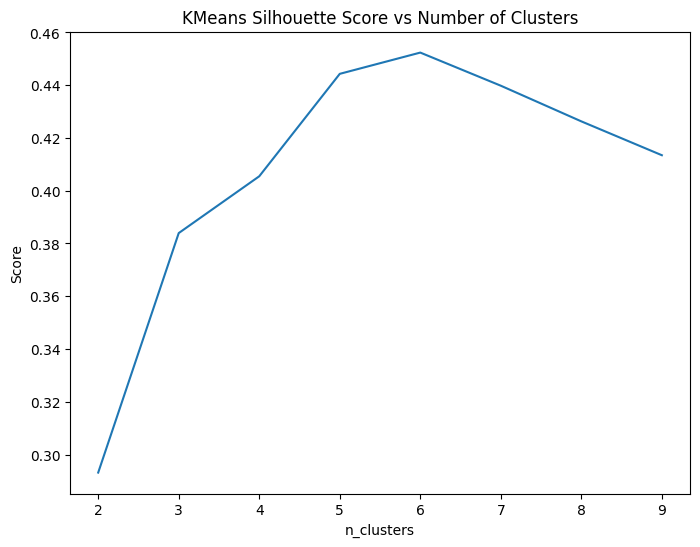

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


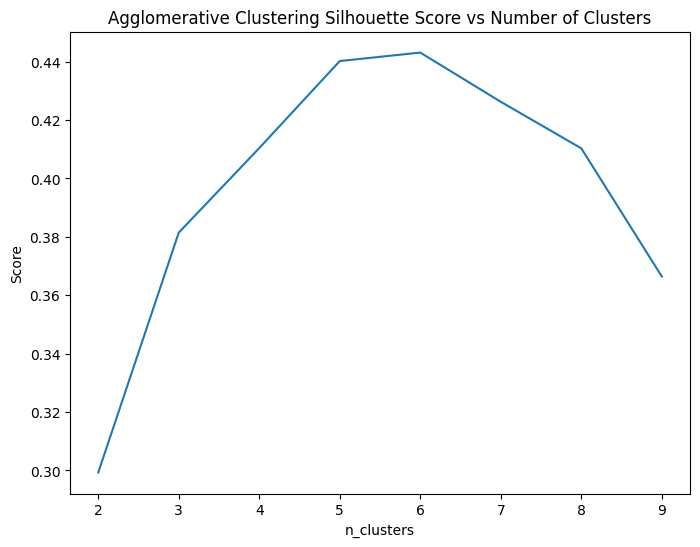

In [36]:
# Separate the results of the silhouette score for each model.
kmeans_results = results[results['Model'] == 'KMeans']
agglo_results = results[results['Model'] == 'AgglomerativeClustering']

# Create a new column for the number of clusters.
kmeans_results['n_clusters'] = kmeans_results['Params'].apply(lambda x: x['n_clusters'])
agglo_results['n_clusters'] = agglo_results['Params'].apply(lambda x: x['n_clusters'])

# Plot the silhouette score for each number of clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.lineplot(x='n_clusters', y='Score', data=kmeans_results)
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.show()

# Plot the silhouette score for each number of clusters for AgglomerativeClustering.
plt.figure(figsize=(8, 6))
sns.lineplot(x='n_clusters', y='Score', data=agglo_results)
plt.title('Agglomerative Clustering Silhouette Score vs Number of Clusters')
plt.show()


The higest silhouette score for both models is a number of cluster equal to 6 but n_clusters = 5 is also very close. I will test both below.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


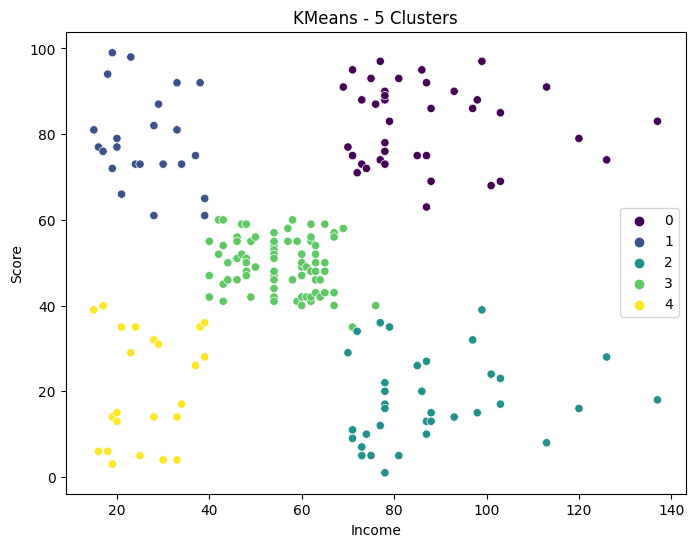

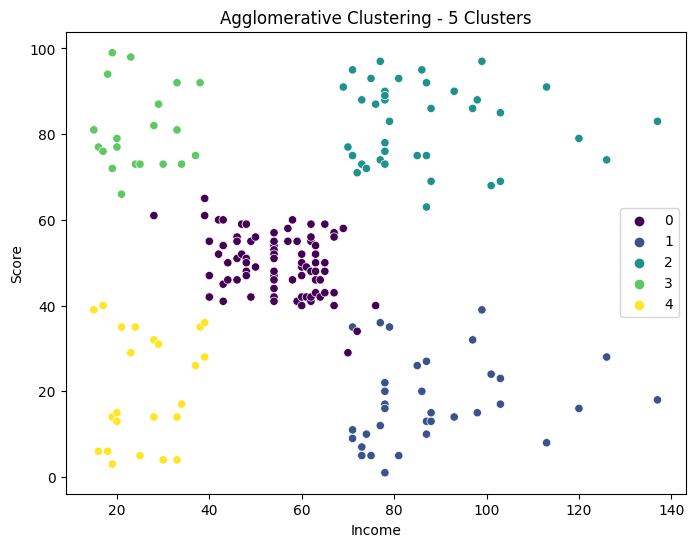

In [37]:
# Set a random seed so we can assign labels. 
np.random.seed(1234)

# Fit the models with the 5 clusters.
kmeans5 = KMeans(n_clusters=5).fit(X)
agglo5 = AgglomerativeClustering(n_clusters=5).fit(X)

# Get the cluster assignments.
kmeans_labels5 = kmeans5.labels_
agglo_labels5 = agglo5.labels_

# Choose Income and Score to plot.
feature1 = 'Income'
feature2 = 'Score'

# Plot the clusters for KMeans with 5 clusters.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=kmeans_labels5, palette='viridis')
plt.title('KMeans - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Plot the clusters for AgglomerativeClustering with 5 clusters.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=agglo_labels5, palette='viridis')
plt.title('Agglomerative Clustering - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()


The clusters for 5 components look pretty uniform, maybe some overlap between the middle cluster and the bottom right cluster when comparing kmeans and agglomerative clustering.

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


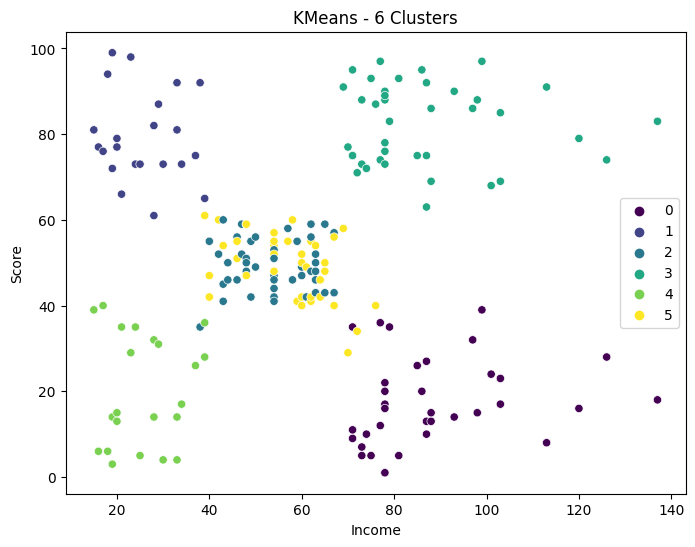

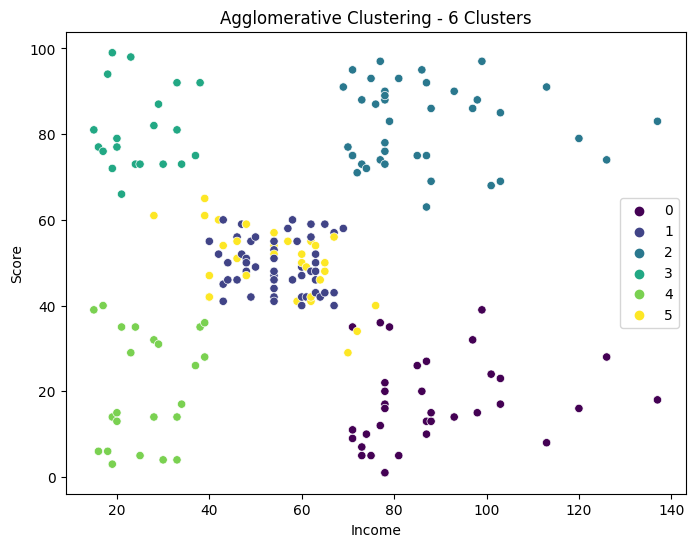

In [38]:
# Fit the models with the 6 clusters.
kmeans6 = KMeans(n_clusters=6).fit(X)
agglo6 = AgglomerativeClustering(n_clusters=6).fit(X)

# Get the cluster assignments.
kmeans_labels6 = kmeans6.labels_
agglo_labels6 = agglo6.labels_

# Assuming X_df is your DataFrame
# X_df = pd.DataFrame(X, columns=numerical_cols)
# print(X_df)

# Choose Income and Score to plot.
feature1 = 'Income'
feature2 = 'Score'

# Plot the 6 clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=kmeans_labels6, palette='viridis')
plt.title('KMeans - 6 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Plot the 6 clusters for AgglomerativeClustering.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=agglo_labels6, palette='viridis')
plt.title('Agglomerative Clustering - 6 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()


With 6 clusters, two clusters are completely overlapping in the middle which is something we don't want. These two clusters are probably better off as being 1 based on their space in the plots and looking at the plots with 5 clusters. 

To recap, for kmeans clustering we had a silhouette score of 0.440453 for 5 clusters and for Agglomerative Clustering we has a silhouette score of 0.440189. Comparing the two plots with 5 components, the plots are almost identical except for a few points in the center cluster. 

For this clustering we can most likely say that our customers fall into 5 buckets:

1. Low score, low income = 'LS-LI'

2. Low score, medium-high income = 'LS-MHI'

3. Medium score, medium income = 'MS-MI'

4. High score, low income = 'HS-LI'

5. High score, medium-high income = 'HS-MHI'

#### Plots of 5 clusters again but with the labels we identified above

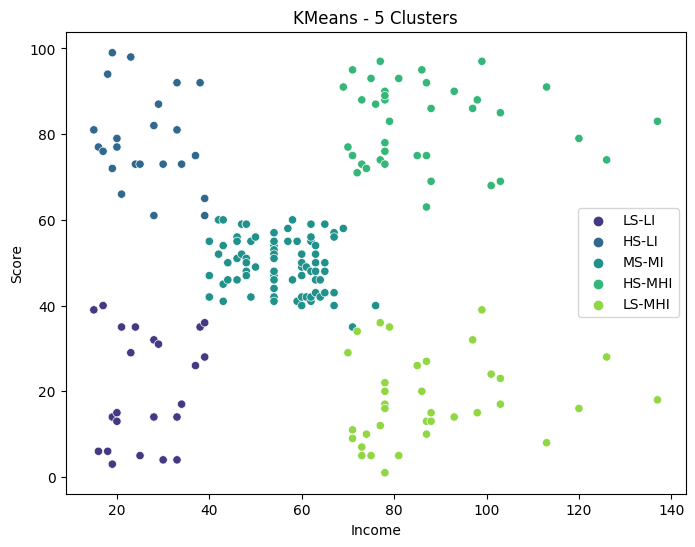

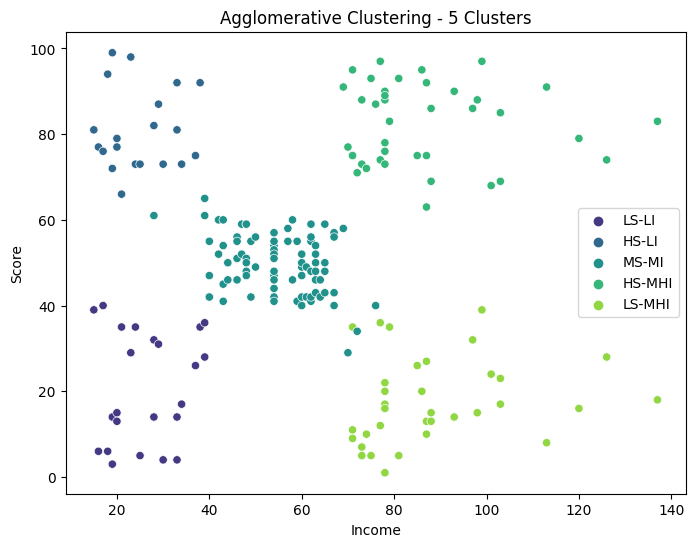

In [39]:
# Defined the mappings.
kmeans_mapping = {4: 'LS-LI', 2: 'LS-MHI', 3: 'MS-MI', 1: 'HS-LI', 0: 'HS-MHI'}
agglo_mapping = {4: 'LS-LI', 1: 'LS-MHI', 0: 'MS-MI', 3: 'HS-LI', 2: 'HS-MHI'}

# Apply the mappings to the labels.
kmeans_labels = [kmeans_mapping[label] for label in kmeans5.labels_]
agglo_labels = [agglo_mapping[label] for label in agglo5.labels_]


# Plot the 5 clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=kmeans_labels, palette='viridis')
plt.title('KMeans - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Plot the 5 clusters for AgglomerativeClustering.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=agglo_labels, palette='viridis')
plt.title('Agglomerative Clustering - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

#### Plots of 5 clusters again but with the labels using Age and Score

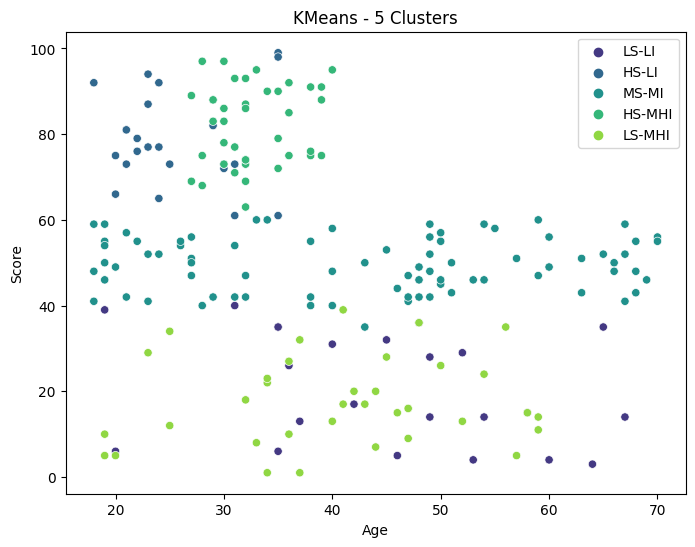

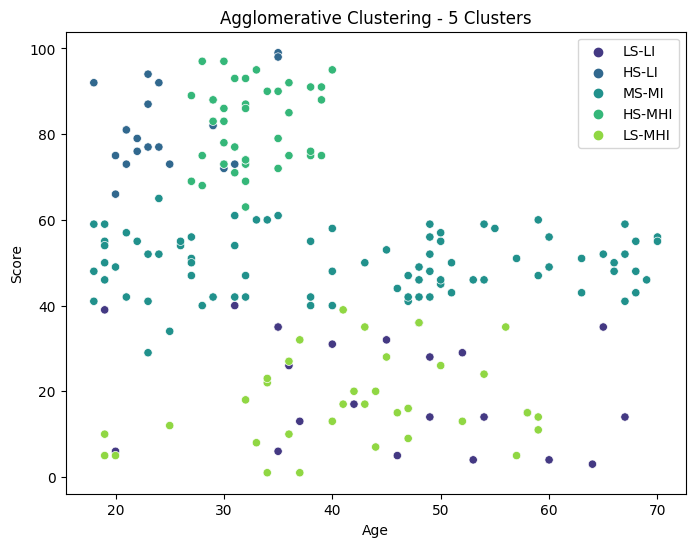

In [40]:
# Choose Age and Score features to plot. 
feature1 = 'Age'
feature2 = 'Score'

# Plot the 5 clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=kmeans_labels, palette='viridis')
plt.title('KMeans - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Plot the 5 clusters for AgglomerativeClustering. 
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[feature1], y=X[feature2], hue=agglo_labels, palette='viridis')
plt.title('Agglomerative Clustering - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()


Looking at the clusters using Age and Score we can make some observations. The 'high score-low income' and 'High score-medium-high income' individuals are about 18-40 in age. The other clusters have a large range of age (18-70). 

## Supervised learning

Now that we have labeled individuals to a give cluster, we could use supervised learning for predicting clusters. Below I use logisitc regression and random forest on the kmeans data. 

In [41]:
# Use kmeans5 labels.
X['KMeans_Labels'] = kmeans5.labels_
print(X.head())

   Age  Income  Score  KMeans_Labels
0   19      15     39              4
1   21      15     81              1
2   20      16      6              4
3   23      16     77              1
4   31      17     40              4


/tmp/ipykernel_33/2113164070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['KMeans_Labels'] = kmeans5.labels_


In [42]:
# Define the feature columns and target column. 
feature_cols = ['Age', 'Income', 'Score']  
target_col = 'KMeans_Labels' 

# Split the data into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(X[feature_cols], X[target_col], test_size=0.2, random_state=1234)

# Initialize the models. 
rf = RandomForestClassifier(random_state=1234)
lr = LogisticRegression(random_state=1234)

# Perform cross-validation and print the results. 
for model in [rf, lr]:
    cv_scores = cross_val_score(model, X_train, y_train, cv=10)
    print(f"{model.__class__.__name__} CV scores: {cv_scores}")

# Fit the models on the training data. 
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Make predictions on the testing data. 
rf_preds = rf.predict(X_test)
lr_preds = lr.predict(X_test)

# Calculate and print the accuracy of the predictions. 
rf_accuracy = accuracy_score(y_test, rf_preds)
lr_accuracy = accuracy_score(y_test, lr_preds)
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"Logistic Regression accuracy: {lr_accuracy}")


RandomForestClassifier CV scores: [1.     1.     1.     0.9375 0.875  1.     1.     1.     1.     1.    ]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression CV scores: [0.8125 0.9375 0.875  0.875  0.6875 0.9375 0.9375 1.     0.9375 0.9375]
Random Forest accuracy: 0.975
Logistic Regression accuracy: 0.95


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


After 10 rounds for each logistic regression and random forest, the random forest has an accuracy of 0.975 and the logistic regression has an accuracy of 0.95. 

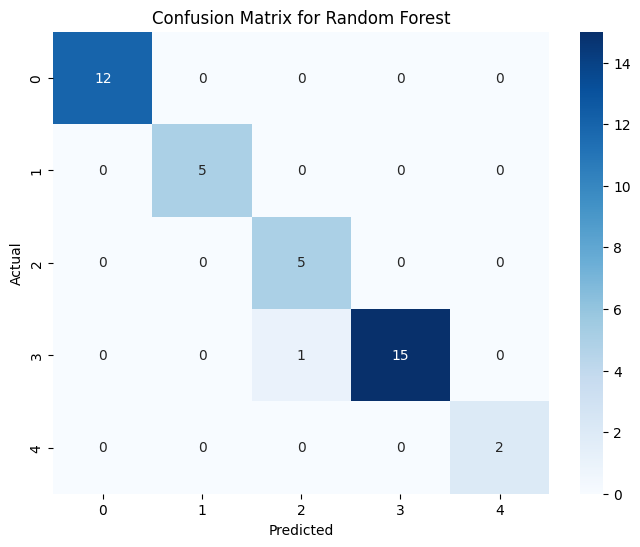

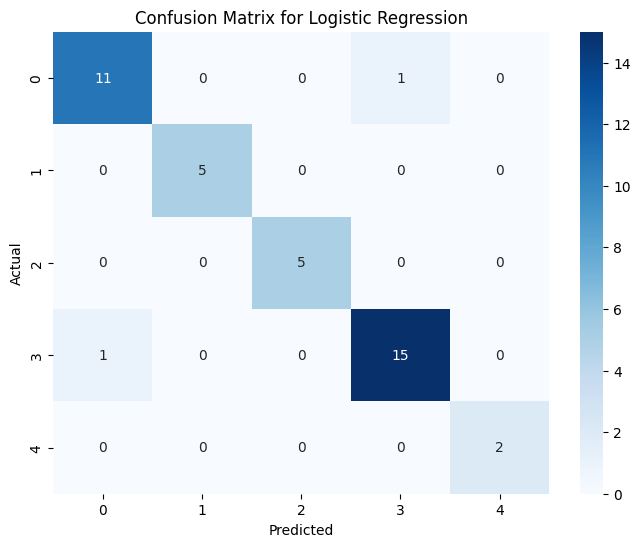

In [43]:
# Calculate confusion matrices. 
rf_cm = confusion_matrix(y_test, rf_preds)
lr_cm = confusion_matrix(y_test, lr_preds)

# Plot confusion matrix for Random Forest. 
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for Logistic Regression. 
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


The random forest seemed to predict a 2 when it was acutally a 3 and the logistic regression seemed to predict a 0 and 3 when it actually was a 3 and a 0, respectively. 

### Simulating more data

In [44]:
# Use kmeans with 5 clusters to simulate data. 
df = X
kmeans_model = kmeans5

# Get the cluster labels for each data point.
labels = kmeans_model.labels_

# Initialize an empty DataFrame to store the simulated data.
simulated_data = pd.DataFrame()

for i in range(5):
    # Filter the data points belonging to a given cluster.
    cluster_data = df[labels == i]
    
    # Get the mean and standard deviation of each feature within each cluster.
    mean_values = cluster_data.mean()
    std_values = cluster_data.std()
    
    # Simulate 10,000 data points from a normal distribution for each feature.
    simulated_cluster = np.random.normal(mean_values, std_values, (10000, len(df.columns)))
    
    # Convert to DataFrame and concatenate with simulated_data.
    simulated_data = pd.concat([simulated_data, pd.DataFrame(simulated_cluster, columns=df.columns)])

    
print(simulated_data.head())
print(len(simulated_data))


         Age      Income      Score  KMeans_Labels
0  34.390844  108.905324  81.855593            0.0
1  29.254536   78.564282  84.961063            0.0
2  32.894167   99.187699  78.924703            0.0
3  33.934695   92.932046  91.783649            0.0
4  37.669633   63.904898  75.405087            0.0
50000


In [45]:
# Calculate the silhouette score for a range of clusters with the simulated data.
def perform_manual_search(X, model, params):
    results = []

    X_train = X

    for n_clusters in params['n_clusters']:
        model.set_params(n_clusters=n_clusters)
        labels = model.fit_predict(X_train)
        score = silhouette_score(X_train, labels)

        results.append({
            'Model': str(model.__class__.__name__),
            'Params': model.get_params(),
            'Score': score,
        })

    return pd.DataFrame(results)

kmeans_params = {'n_clusters': range(2, 10)}

# Save the results of each run. 
kmeans_results = perform_manual_search(simulated_data, KMeans(), kmeans_params)

# Print the DataFrame. 
print(kmeans_results)


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

    Model                                             Params     Score
0  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.339921
1  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.384365
2  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.456434
3  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.486742
4  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.452016
5  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.420335
6  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.389458
7  KMeans  {'algorithm': 'lloyd', 'copy_x': True, 'init':...  0.356401


/tmp/ipykernel_33/243644149.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmeans_results['n_clusters'] = kmeans_results['Params'].apply(lambda x: x['n_clusters'])
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


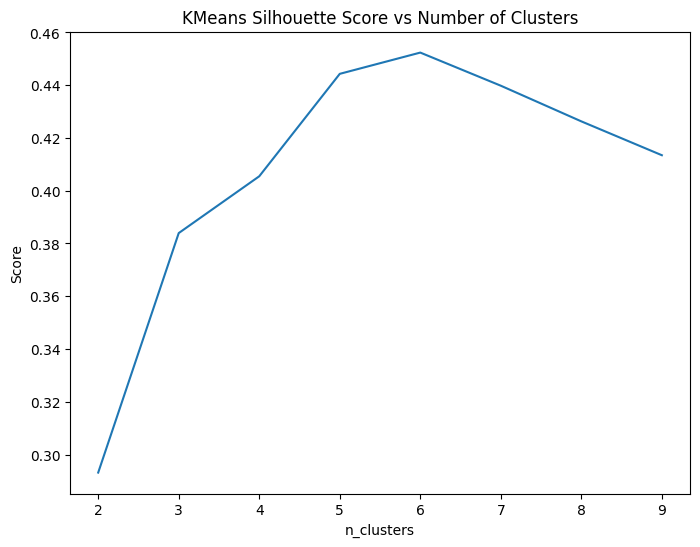

In [46]:
# Separate the results of the silhouette score for each model.
kmeans_results = results[results['Model'] == 'KMeans']

# Create a new column for the number of clusters.
kmeans_results['n_clusters'] = kmeans_results['Params'].apply(lambda x: x['n_clusters'])

# Plot the silhouette score for each number of clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.lineplot(x='n_clusters', y='Score', data=kmeans_results)
plt.title('KMeans Silhouette Score vs Number of Clusters')
plt.show()

Once again, number of clusters of 5 or 6 would be a good starting point for the simulated data. 

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


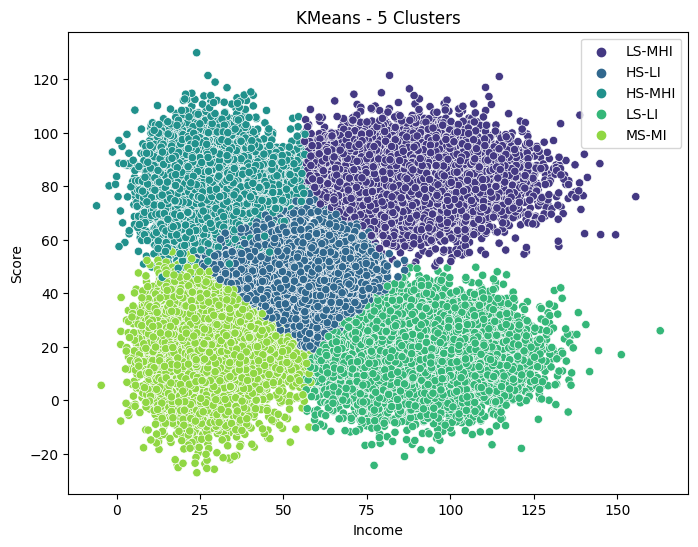

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


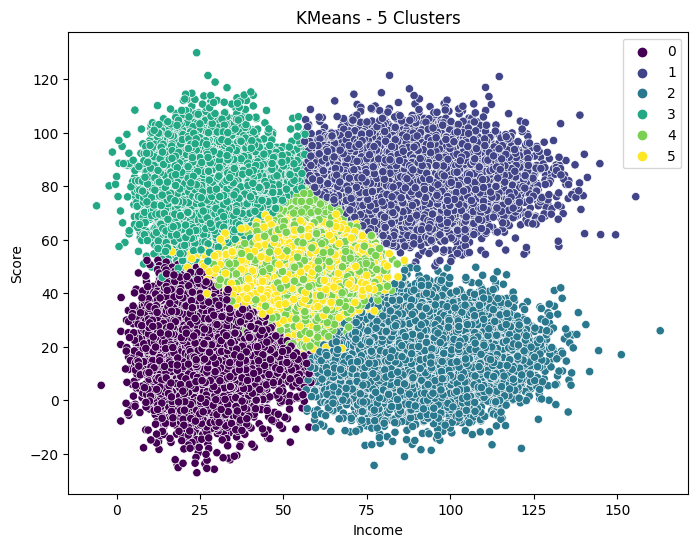

In [47]:
# Fit the new model with 5 clusters.
new_kmeans_model = KMeans(n_clusters=5).fit(simulated_data)

# Defined the mappings for the 5 clusters.
kmeans_mapping = {4: 'LS-LI', 2: 'LS-MHI', 3: 'MS-MI', 1: 'HS-LI', 0: 'HS-MHI'}

# Apply the mappings to the labels.
kmeans_labels = [kmeans_mapping[label] for label in new_kmeans_model.labels_]

# Choose Income and Score to plot.
feature1 = 'Income'
feature2 = 'Score'

# Plot the 5 clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=simulated_data[feature1], y=simulated_data[feature2], hue=kmeans_labels, palette='viridis')
plt.title('KMeans - 5 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()

# Fit the new model with 6 clusters.
new_kmeans_model6 = KMeans(n_clusters=6).fit(simulated_data)

# Choose Income and Score to plot.
feature1 = 'Income'
feature2 = 'Score'

# Plot the 6 clusters for KMeans.
plt.figure(figsize=(8, 6))
sns.scatterplot(x=simulated_data[feature1], y=simulated_data[feature2], hue=new_kmeans_model6.labels_, palette='viridis')
plt.title('KMeans - 6 Clusters')
plt.xlabel(feature1)
plt.ylabel(feature2)
plt.show()




Once again, when using 6 clusters the middle cluster consists of 2. For this reason, 5 would be a good number of clusters. Looking at the plot with 5 clusters, there is a lot more overlap in that center cluster with more people and defining a good cutoff point is becoming tougher. These cluster or bins of people can be used for different marketing strategies. If available we could look at the types of product people from certain clusters buy and start recommending those same products or similar products to pepole in those clusters who have not bought that item yet. 

In [49]:
# Use kmeans5 labels.
simulated_data['KMeans_Labels'] = new_kmeans_model.labels_
print(X.head())

# Define the feature columns and target column. 
feature_cols = ['Age', 'Income', 'Score']  
target_col = 'KMeans_Labels' 

# Split the data into training and testing sets. 
X_train, X_test, y_train, y_test = train_test_split(simulated_data[feature_cols], simulated_data[target_col], test_size=0.2, random_state=1234)

# Initialize the models. 
rf = RandomForestClassifier(random_state=1234)
lr = LogisticRegression(random_state=1234)

# Perform cross-validation and print the results. 
for model in [rf, lr]:
    cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    print(f"{model.__class__.__name__} CV scores: {cv_scores}")

# Fit the models on the training data. 
rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Make predictions on the testing data. 
rf_preds = rf.predict(X_test)
lr_preds = lr.predict(X_test)

# Calculate and print the accuracy of the predictions. 
rf_accuracy = accuracy_score(y_test, rf_preds)
lr_accuracy = accuracy_score(y_test, lr_preds)
print(f"Random Forest accuracy: {rf_accuracy}")
print(f"Logistic Regression accuracy: {lr_accuracy}")


   Age  Income  Score  KMeans_Labels
0   19      15     39              4
1   21      15     81              1
2   20      16      6              4
3   23      16     77              1
4   31      17     40              4
RandomForestClassifier CV scores: [0.994375 0.99525  0.994    0.995    0.995625]


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegression CV scores: [0.942    0.944625 0.940875 0.945375 0.958875]
Random Forest accuracy: 0.9944
Logistic Regression accuracy: 0.9547


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest has an accuracy of 0.9944 and logistic regression accuracy of 0.9547. 

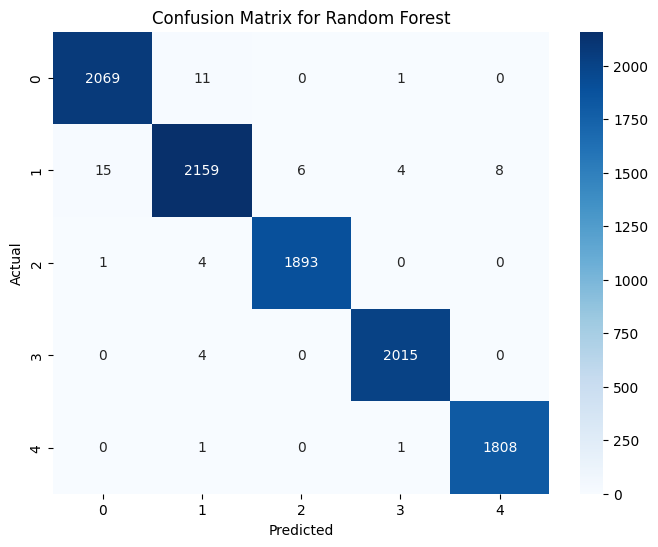

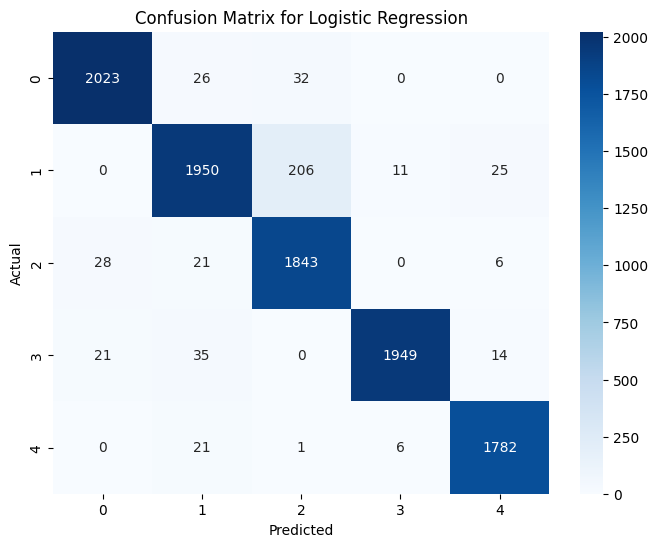

In [50]:
# Calculate confusion matrices. 
rf_cm = confusion_matrix(y_test, rf_preds)
lr_cm = confusion_matrix(y_test, lr_preds)

# Plot confusion matrix for Random Forest. 
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Plot confusion matrix for Logistic Regression. 
plt.figure(figsize=(8, 6))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


Random forest had better predictions when comparing to the actual simulated data. 

## Discussion/Conclusion

In this dataset we started with mall customer data which contained data such as Customer ID, age, gender, annual income and spending score. Exploratory data analysis was pretty simple for this dataset but it confirmed that there were no null values or duplicates. Following that there was not much correlation between the columns of data. PCA was used to see how many principal components explain most of the data and it turned out to be 2 PCs. If there were more data, PCA could be useful in reducing our dimensions but since it was only two which explained all of the data, all of the data was used. 

Next, using Kmeans clustering and calculating the inertia and elbow plot was made to find a good number of clusters for the algorithms we wanted to test. We found 3, 5, and 6 cluster could be a good amount for Kmeans and Agglomerative clustering. Another score, as well as plots, were used to confirm how many cluster we should use. That was the silhouette score, which looked at how distinct the clusters were. The highest silhouette scores were 5 and 6 for both algorithms. When looking at the plots, 5 cluster turned out better because it didn't really have overlapping clusters. 

Following clustering, the cluster labels were assigned to the customers and random forest and logistic regression was used to predict cluster labels. Random Forest had an accuracy of 0.975 and logistic regression had an accuracy of 0.95. 

The data was easy to work with but the biggest downside of it was how small it was. With only 200 rows and not much to fix, it didn't resemble a more real world situation. This led me to simulating data, albeit I used a normal distribution for each cluster which maintained the clusters well. I ran the silhouette score and Kmeans again, plotting the results and re-running the supervised learning algorithms. The random forest had an accuracy of 0.9944 and logistic regression had an accuracy of 0.9547. This could be used to predict the cluster a newer customer might fall into. 

Additionally, if there were data on products these customers bought, we would be able to recommend those products or similar products of people that are in the same cluster. This could bring in more revenue to the company. 